# В этом файле мы восстанавливаем 3d координаты из 2d с помощью уравнения плоскости

In [1]:
import numpy as np
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib nbagg

In [2]:
def get_info_calibrate_camera():
    """
    Возвращает информацию, необходимую для исключения искажений с изображений
    """
    import pickle
    f = open("data_of_calibrate_camera.pckl", "rb")
    ret = pickle.load(f)
    mtx = pickle.load(f)
    dist = pickle.load(f)
    rvecs = pickle.load(f)
    tvecs = pickle.load(f)
    return ret, mtx, dist, rvecs, tvecs

In [3]:
def get_corners(frame):
    """
    frame_markers - изображение с обведенными маркерами
    ids - мапа для массива и закодированного в маркере числа
    corners - массив углов маркеров
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
    parameters =  aruco.DetectorParameters_create()
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, 
                                                          parameters=parameters)
    # SUB PIXEL DETECTION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
    for corner in corners:
        cv2.cornerSubPix(gray, corner, winSize = (3,3), zeroZone = (-1,-1), criteria = criteria)
        
    frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

    return frame_markers, ids, corners

In [4]:
def get_plane_equation(tvecs):
    """
    Тут мы получаем уравнение плоскости из заданных 3d координат tvecs
    Этот участок кода зависит от того, какую ArucoBoard мы используем. Сейчас он написан для board.png
    """    
    # Хорошо бы тут переписать без говнокода выбор точек не на одной прямой
    mat_plane_solve = [None]*len(tvecs-2)
    mat_plane_solve = np.array(mat_plane_solve)
    mat_plane_end = [0.]*3 #говнокод, но работает
    mat_plane_end = np.array(mat_plane_end) # среднее значение коэфф уравнения плоскости
    
    for i in range(len(tvecs)-2):
        if (i != 5 and i!=8): #выкинули неверные уравнения, тк точки на одной прямой
            mat_plane_a = np.array([tvecs[i][0],tvecs[i+1][0],tvecs[i+2][0]])
            mat_plane_b = np.array([[-1],[-1],[-1]])
            mat_plane_solve[i] = np.linalg.solve(mat_plane_a,mat_plane_b)
            #print("i = ", i)
            #print(mat_plane_solve[i])
            for j in range(3):
                mat_plane_end[j] += float(mat_plane_solve[i][j][0])/(len(tvecs)-2)
                #print(float(mat_plane_solve[i][j][0])/float(mat_plane_solve[i][0][0]))
        #print(mat_plane_solve)
    return mat_plane_end

In [5]:
def get_2D_from_3D(x_3d):
    """
    Функция переводит 3D координаты в 2D координаты пикселей на экране
    """
    #x_3d =np.array([[tvecs[i][0][0]],[tvecs[i][0][1]],[tvecs[i][0][2]]])
    #print(x_3d) # - 3d координаты
    x_2d = np.matmul(mtx,x_3d) # Ненормализованный вектор 2d координат
    #print(x_2d) 
    
    #Нормализуем x_2d
    x_2d = list(x_2d)
    x0 = x_2d[0]/x_2d[2]
    y0 = x_2d[1]/x_2d[2]
    
    return np.array([x0,y0])

In [6]:
def plot_point_on_frame(frame_markers, x):
    """
    Рисует картинку с желтыми точками в координатах x[0],x[1]
    """
    plt.figure(figsize=(10, 8), dpi=80)
    plt.imshow(frame_markers, interpolation = "nearest")
    for i in range(len(x[0])):
        plt.scatter(x[0], x[1], s=100,color = 'yellow') # рисуем точку в месте полученных координат, и она у нас соглась с исходной!
    plt.show()

In [20]:
def get_3D_from_2D(mtx, mat_plane_end,x):
    x1_2d = np.array([x[0],x[1],[1]])# перевели 2D координаты в np.arr
    invmtx = np.linalg.inv(mtx) # Обратная матрица к матрице преобразования координат 2d->3d
    x1_3d = np.matmul(invmtx,x1_2d) # Сырые, неподогнанные, с точностью до множителя координаты. 
    # Нам необходимо подогнать множитель для x1_3d
    m = -1/(np.matmul(mat_plane_end,x1_3d)) # mat_plane_end - коэффициенты уравнения плоскости
    x_end_3d = x1_3d*m # c учетом подгона того факта, что точка на плоскости

    #print(x_end_3d)
    #print()
    #print(x_3d)
    return x_end_3d

In [21]:
def get_deviation_vec(x1,x2):
    dx = 0
    for i in range(3):
        dx += ((float(x1[i][0])-float(x2[i][0]))*x1[i][0])**2
    dx = dx**0.5*100
    return dx

### Достанем результат калибровки:

In [7]:
ret, mtx, dist, rvecs, tvecs = get_info_calibrate_camera()

### Вытащим картинку для калибровки + undistord её + рисуем corners

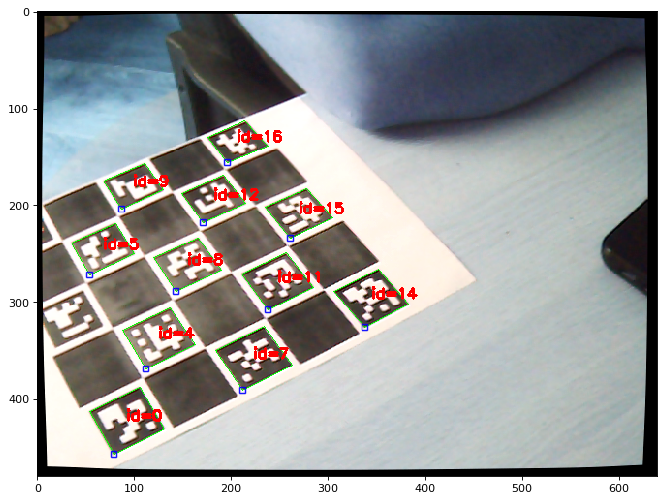

In [8]:
# Нарисуем изображение с обведенными маркерами
frame_dist = cv2.imread('./../data/test_coordinates/real_coordinates.png')
frame = cv2.undistort(src = frame_dist, cameraMatrix = mtx, distCoeffs = dist)

frame_markers, ids, corners = get_corners(frame)
plt.figure(figsize=(10, 8), dpi=80)
plt.imshow(frame_markers, interpolation = "nearest")

plt.show()

### Получим информацию о маркерах с калибровочной доски для задания плоскости

In [9]:
#Надо исправить size_of_marker 
size_of_marker =  0.0285 # side lenght of the marker in meter
rvecs,tvecs,_objPoints  = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)
print(tvecs)

[[[ 0.00922013  0.02342506  0.37863069]]

 [[-0.07658817 -0.07369071  0.4679236 ]]

 [[-0.12091797  0.08791677  0.38489434]]

 [[-0.05191442  0.05342847  0.3713561 ]]

 [[-0.10770751  0.0459721   0.39705221]]

 [[-0.04194685  0.01477436  0.38933712]]

 [[-0.09654319  0.00571684  0.41531465]]

 [[-0.15357569 -0.00374991  0.4395323 ]]

 [[-0.03209491 -0.02378617  0.41089377]]

 [[-0.08576757 -0.03378969  0.43695894]]

 [[-0.14192018 -0.04413054  0.46149366]]]


In [10]:
print(ids.flatten())

[14 16  0  7  4 11  8  5 15 12  9]


In [11]:
data = pd.DataFrame(data = tvecs.reshape(len(tvecs),3), columns = ["tx", "ty", "tz"], 
                    index = ids.flatten())
data.index.name = "marker"
data.sort_index(inplace= True)
data
#print(data.loc[0:1].values[0])

,tx,ty,tz
marker,,,
0,-0.120918,0.087917,0.384894
4,-0.107708,0.045972,0.397052
5,-0.153576,-0.003750,0.439532
7,-0.051914,0.053428,0.371356
8,-0.096543,0.005717,0.415315
9,-0.141920,-0.044131,0.461494
11,-0.041947,0.014774,0.389337
12,-0.085768,-0.033790,0.436959
14,0.009220,0.023425,0.378631


## Получим уравнение плоскости
https://ege-ok.ru/2012/03/18/uravnenie-ploskosti

In [12]:
mat_plane_end = get_plane_equation(tvecs) # среднее значение коэфф уравнения плоскости
print(mat_plane_end) 

[-0.79373893 -1.18618008 -2.03176126]


## Далее получим 2d координаты точки из 3d:

In [13]:
i = 2 #выбираем точку 
x_3d = np.array([[tvecs[i][0][0]],[tvecs[i][0][1]],[tvecs[i][0][2]]])
x = get_2D_from_3D(x_3d)

print(x)

[[ 97.30192692]
 [416.8880741 ]]


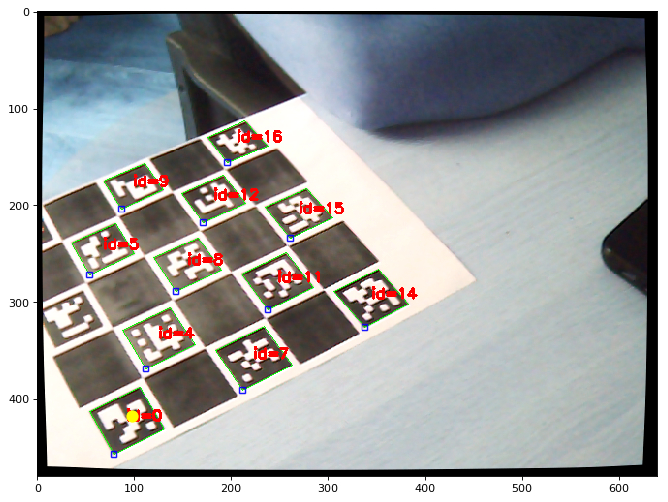

In [14]:
plot_point_on_frame(frame_markers,x)

# Получим 3d координаты из 2d

In [16]:
# Проверим работоспособность преобразований.
print(x_3d)
x = get_2D_from_3D(x_3d)
x_3d_new = get_3D_from_2D(mtx, mat_plane_end,x)
print (x_3d_new)

[[-0.12091797]
 [ 0.08791677]
 [ 0.38489434]]
[[-0.15299851]
 [ 0.11124182]
 [ 0.48701   ]]


### Оценим погрешность результата:

In [18]:
dx = get_deviation_vec(x_3d, x_3d_new)
print(dx,"%")
# Наша погрешность получилась < 6% для всех точек Имхо, более чем норм (подозрение на низкое качество калибровки)

3.9547902839584053 %


### Убедимся, что на 2d x_3d и x_3d_new - одни и те же точки в 2d

In [22]:
x1 = get_2D_from_3D(x_3d_new)
print(x)
print(x1)
#plot_point_on_frame(frame_markers, x1)

[[ 97.30192692]
 [416.8880741 ]]
[[ 97.30192692]
 [416.8880741 ]]
